# ЗАДАНИЕ 3 #
 

## УСЛОВИЕ: ##
Необходимо произвести предобработку данных, обучить модели на алгоритмах, рассмотренных в уроках, оценить модели с помощью рассмотренных метрик и объяснить выбор определенной метрики.

**Описание данных**

* Pclass — класс пассажира (1 — высший, 2 — средний, 3 — низший);
* Name — имя;
* Sex — пол;
* Age — возраст;
* SibSp — количество братьев, сестер, сводных братьев, сводных сестер, супругов на борту титаника;
* Parch — количество родителей, детей (в том числе приемных) на борту титаника;
* Ticket — номер билета;
* Fare — плата за проезд;
* Cabin — каюта;
* Embarked — порт посадки (C — Шербур; Q — Квинстаун; S — Саутгемптон).

# Импортируем необходимые библиотеки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve, auc,
                             classification_report)
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import RocCurveDisplay

# Прочитаем файл

In [2]:
df = pd.read_csv('https://lms.skillfactory.ru/asset-v1:SkillFactory+MIPTDS+SEPT22+type@asset+block@train.csv', index_col=0)
df.head(2)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [4]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Пропуски в данных

In [5]:
df.isna().agg(['sum', 'mean']).T.rename({'sum': 'кол-во', 'mean': 'доля'}, axis=1)

,кол-во,доля
Survived,0.0,0.000000
Pclass,0.0,0.000000
Name,0.0,0.000000
Sex,0.0,0.000000
Age,177.0,0.198653
SibSp,0.0,0.000000
Parch,0.0,0.000000
Ticket,0.0,0.000000
Fare,0.0,0.000000
Cabin,687.0,0.771044


# Признаки

### 1. Survived — выжил пассажир или погиб 
**(0 — погиб, 1 — выжил)**

Более 60% пассажиров погибли

In [6]:
survived_df = df.Survived.value_counts(normalize=True) * 100
survived_df.index = ['Не выжили', 'Выжили']
survived_df

Не выжили    61.616162
Выжили       38.383838
Name: Survived, dtype: float64

### 2. Pclass — класс пассажира
**(1 — высший, 2 — средний, 3 — низший)**

In [7]:
cros_df = (pd.crosstab(df['Pclass'], df['Survived'], margins=True)
               .apply(lambda x: round(x / x.All * 100, 2), axis=1)).iloc[:-1, :-1][[1, 0]]
cros_df.columns = ['Выжили', 'Не выжили']
cros_df.index = ['Класс 1', 'Класс 2', 'Класс 3']
cros_df

,Выжили,Не выжили
Класс 1,62.96,37.04
Класс 2,47.28,52.72
Класс 3,24.24,75.76


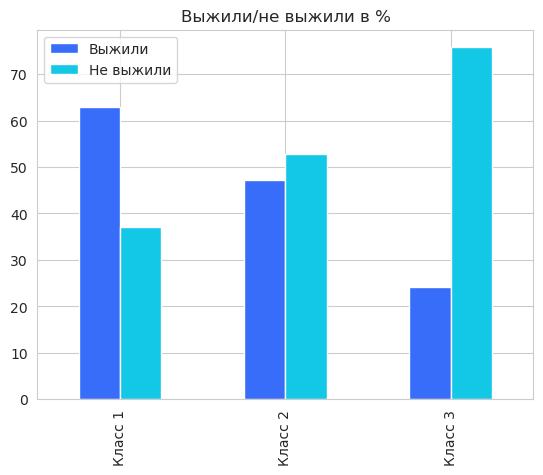

In [8]:
with sns.axes_style('whitegrid'), sns.color_palette('rainbow'):
    cros_df.plot.bar().set_title('Выжили/не выжили в %')

In [9]:
df.Pclass.value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

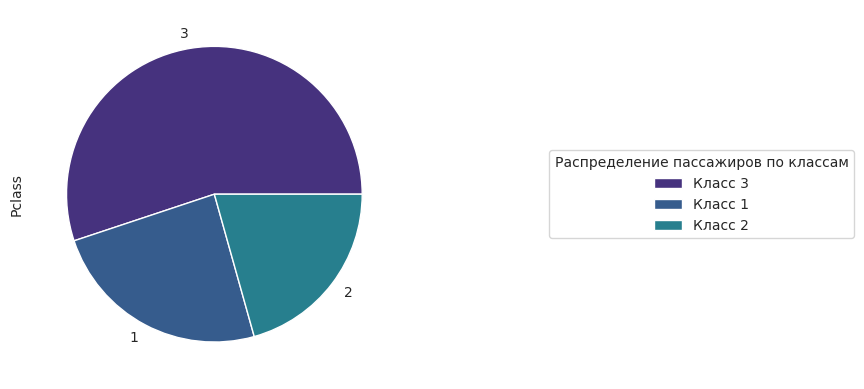

In [10]:
with sns.axes_style('whitegrid'), sns.color_palette('viridis'):
    (df.Pclass.value_counts().plot.pie().legend(labels=["Класс 3","Класс 1","Класс 2"],
    loc='center right', bbox_to_anchor=(2.25, 0.5)).set_title('Распределение пассажиров по классам'))

### 3. Sex — пол

Среди пассажиров было 65% мужчин и 35 % женщин.

In [11]:
(df.Sex.value_counts(normalize=True) * 100).apply(lambda x: round(x, 2))

male      64.76
female    35.24
Name: Sex, dtype: float64

**74% женщин**, из находящихся на борту, **выжили**, в то время как около **80% мужчин - погибли**.

In [12]:
cros_df = (pd.crosstab(df['Sex'], df['Survived'], margins=True)
           .apply(lambda x: round(x / x.All * 100, 2), axis=1)).iloc[:-1, :-1][[1, 0]]
cros_df.columns = ['Выжили', 'Не выжили']
cros_df.index = ['Женщины', 'Мужчины']
cros_df

,Выжили,Не выжили
Женщины,74.20,25.80
Мужчины,18.89,81.11


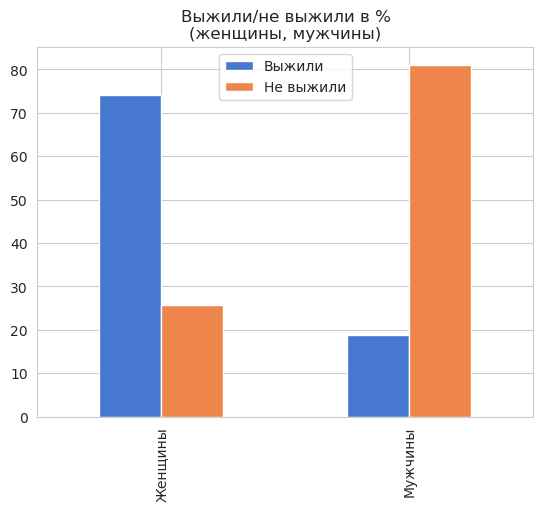

In [13]:
with sns.axes_style('whitegrid'), sns.color_palette('muted'):
    cros_df.plot.bar().set_title('Выжили/не выжили в %\n(женщины, мужчины)')

**60% мужчин находились в 3-ем классе**, отчасти это объясняет большой процент погибших среди мужчин

In [14]:
cros_df = (pd.crosstab(df['Sex'], df['Pclass'], margins=True)
               .apply(lambda x: round(x / x.All * 100, 2), axis=1)).iloc[:-1, :-1]
cros_df.index = ['Женщины', 'Мужчины']
cros_df.columns = ['Класс 1', 'Класс 2', 'Класс 3']
cros_df

,Класс 1,Класс 2,Класс 3
Женщины,29.94,24.20,45.86
Мужчины,21.14,18.72,60.14


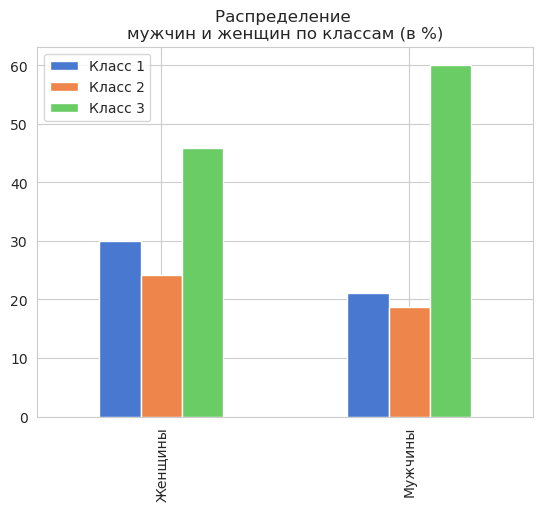

In [15]:
with sns.axes_style('whitegrid'), sns.color_palette('muted'):
    cros_df.plot.bar().set_title('Распределение \nмужчин и женщин по классам (в %)')

### 4. Age — возраст

Средний возраст пассажиров около 30 лет, а самому старшему было 80 лет.

In [16]:
df.Age.describe().loc[['mean', 'min', 'max']]

mean    29.699118
min      0.420000
max     80.000000
Name: Age, dtype: float64

Добавим колонку с диапазоном возрастов, разбив всех пассажиров на группы 0-10, 10-20, 20-30 ... 70-80 лет.

In [17]:
df['Age_Range'] = pd.cut(df.Age, [0, 10, 20, 30, 40, 50, 60, 70, 80])

In [18]:
cros_df = pd.crosstab(df['Age_Range'], df['Survived'])
cros_df.columns = ['Погибли', 'Выжили']
cros_df.index.name = 'Возрастные группы'
cros_df

,Погибли,Выжили
Возрастные группы,,
"(0, 10]",26,38
"(10, 20]",71,44
"(20, 30]",146,84
"(30, 40]",86,69
"(40, 50]",53,33
"(50, 60]",25,17
"(60, 70]",13,4
"(70, 80]",4,1


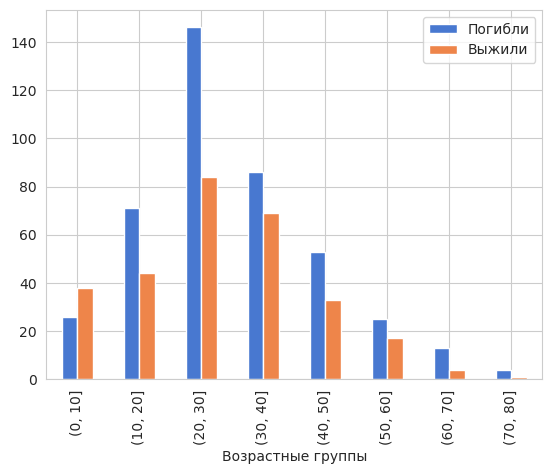

In [19]:
with sns.axes_style('whitegrid'), sns.color_palette('muted'):
    cros_df.plot.bar()

In [20]:
cros_df = (pd.crosstab(df['Age_Range'], df['Pclass'], margins=True)
          .apply(lambda x: round(x / x.All * 100, 2), axis=1)).iloc[:-1, :-1]
cros_df.columns = ['Класс 1', 'Класс 2', 'Класс 3']
cros_df.index.name = 'Возрастные группы'
cros_df

,Класс 1,Класс 2,Класс 3
Возрастные группы,,,
"(0, 10]",4.69,26.56,68.75
"(10, 20]",15.65,15.65,68.70
"(20, 30]",17.39,26.52,56.09
"(30, 40]",31.61,27.74,40.65
"(40, 50]",43.02,22.09,34.88
"(50, 60]",59.52,28.57,11.90
"(60, 70]",64.71,17.65,17.65
"(70, 80]",60.00,0.00,40.00


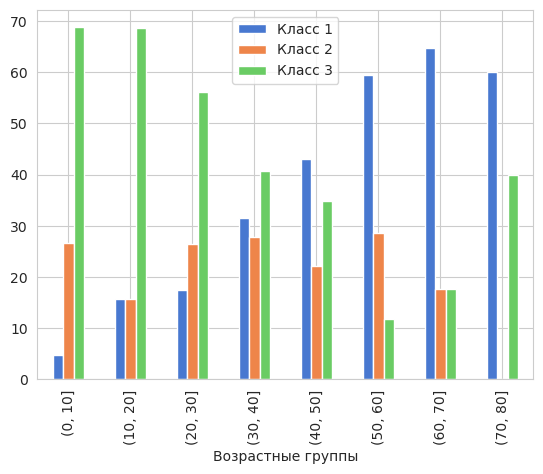

In [21]:
with sns.axes_style('whitegrid'), sns.color_palette('muted'):
    cros_df.plot.bar()

Распределение возрастных групп по классам в %

In [22]:
cros_df = (pd.crosstab(df['Pclass'], df['Age_Range'], margins=True)
          .apply(lambda x: round(x / x.All * 100, 2), axis=1)).iloc[:-1, :-1]
cros_df.index = ['Класс 1', 'Класс 2', 'Класс 3']
cros_df.columns.name = 'Возрастные группы'
cros_df

Возрастные группы,"(0, 10]","(10, 20]","(20, 30]","(30, 40]","(40, 50]","(50, 60]","(60, 70]","(70, 80]"
Класс 1,1.61,9.68,21.51,26.34,19.89,13.44,5.91,1.61
Класс 2,9.83,10.40,35.26,24.86,10.98,6.94,1.73,0.00
Класс 3,12.39,22.25,36.34,17.75,8.45,1.41,0.85,0.56


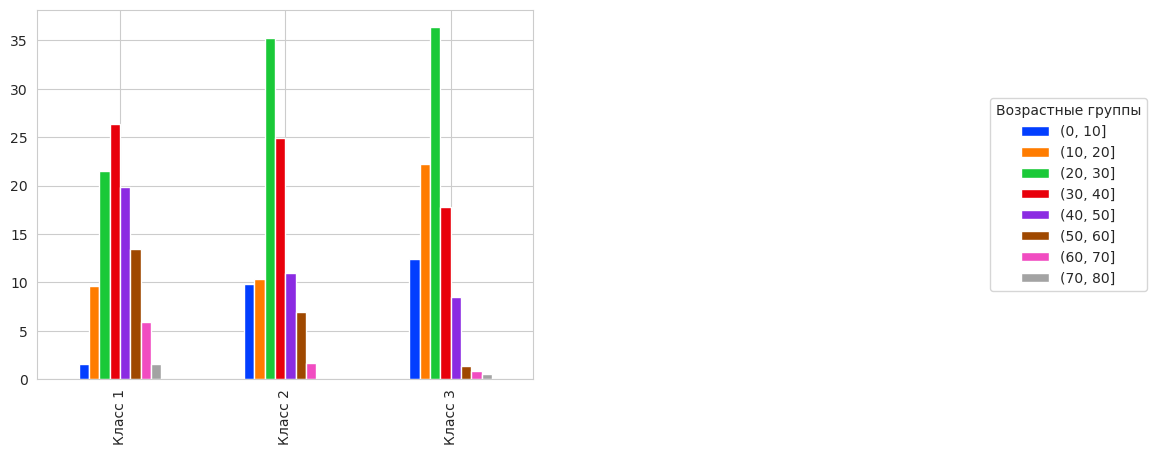

In [23]:
with sns.axes_style('whitegrid'), sns.color_palette('bright'):
    cros_df.plot.bar().legend(loc='center right', bbox_to_anchor=(2.25, 0.5)).set_title('Возрастные группы')

### 5. SibSp — количество братьев, сестер, сводных братьев, сводных сестер, супругов на борту титаника

Более 90% пассажиров путешествовали в одиночку или вдвоем

In [24]:
df.SibSp.value_counts(normalize=True).apply(lambda x: round(x * 100, 2))

0    68.24
1    23.46
2     3.14
4     2.02
3     1.80
8     0.79
5     0.56
Name: SibSp, dtype: float64

С ростом SibSp шансы на спасение снижались

In [25]:
cros_df = (pd.crosstab(df['SibSp'], df['Survived'], margins=True)
          .apply(lambda x: round(x / x.All * 100, 2), axis=1)).iloc[:-1, :-1]
cros_df.columns = ['Погибли в %', 'Спаслись в %']
cros_df

,Погибли в %,Спаслись в %
SibSp,,
0,65.46,34.54
1,46.41,53.59
2,53.57,46.43
3,75.00,25.00
4,83.33,16.67
5,100.00,0.00
8,100.00,0.00


### 6. Parch — количество родителей, детей (в том числе приемных) на борту титаника

In [26]:
cros_df = (pd.crosstab(df['Parch'], df['Survived'], margins=True)
          .apply(lambda x: round(x / x.All * 100, 2), axis=1)).iloc[:-1, :-1]
cros_df.columns = ['Погибли в %', 'Спаслись в %']
cros_df

,Погибли в %,Спаслись в %
Parch,,
0,65.63,34.37
1,44.92,55.08
2,50.00,50.00
3,40.00,60.00
4,100.00,0.00
5,80.00,20.00
6,100.00,0.00


Создадим признак 'Family' и проанализируем его влияние на шансы на спасение

In [27]:
df['Family'] = df['SibSp'] + df['Parch']

Шансы на спасение были значительно выше у тех, кто имел на борту не более 3 членов семьи

In [28]:
cros_df = (pd.crosstab(df['Family'], df['Survived'], margins=True)
          .apply(lambda x: round(x / x.All * 100, 2), axis=1)).iloc[:-1, :-1]
cros_df.columns = ['Погибли в %', 'Спаслись в %']
cros_df

,Погибли в %,Спаслись в %
Family,,
0,69.65,30.35
1,44.72,55.28
2,42.16,57.84
3,27.59,72.41
4,80.00,20.00
5,86.36,13.64
6,66.67,33.33
7,100.00,0.00
10,100.00,0.00


Добавим аттрибут большой семьи

In [29]:
df['Big_Family'] = df.Family > 3

### 7. Embarked — порт посадки

**(C — Шербур; Q — Квинстаун; S — Саутгемптон)**

Люди, севшие на пароход в Шербуре, имели более высокие шансы на спасение

In [30]:
cros_df = (pd.crosstab(df['Embarked'], df['Survived'], margins=True)
          .apply(lambda x: round(x / x.All * 100, 2), axis=1)).iloc[:-1, :-1]
cros_df.columns = ['Погибли в %', 'Спаслись в %']
cros_df.index = ['Шербур', 'Квинстаун', 'Саутгемптон']
cros_df.index.name = 'Порт посадки'
cros_df

,Погибли в %,Спаслись в %
Порт посадки,,
Шербур,44.64,55.36
Квинстаун,61.04,38.96
Саутгемптон,66.30,33.70


## Заполнение пропусков

In [31]:
df_cabin_na = pd.DataFrame({'Pclass': df[df['Cabin'].isna()]['Pclass'].value_counts(), 'All_Pclass': df.Pclass.value_counts()})

Более 90% записей не имеют информацию о номере каюты

In [32]:
df_cabin_na['na'] = round(df_cabin_na.Pclass / df_cabin_na.All_Pclass * 100, 2)
df_cabin_na

,Pclass,All_Pclass,na
1,40,216,18.52
2,168,184,91.30
3,479,491,97.56


Я решил удалить признак 'Cabin', а также 'Name', 'Fare', 'Ticket', 'SibSp', 'Parch', 'Age', 'Age_Range', 'Embarked'.

In [33]:
# df.drop(['Cabin', 'Name', 'Fare', 'Ticket', 'SibSp', 'Parch', 'Age', 'Age_Range', 'Embarked'], axis=1, inplace=True)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Survived    891 non-null    int64   
 1   Pclass      891 non-null    int64   
 2   Name        891 non-null    object  
 3   Sex         891 non-null    object  
 4   Age         714 non-null    float64 
 5   SibSp       891 non-null    int64   
 6   Parch       891 non-null    int64   
 7   Ticket      891 non-null    object  
 8   Fare        891 non-null    float64 
 9   Cabin       204 non-null    object  
 10  Embarked    889 non-null    object  
 11  Age_Range   714 non-null    category
 12  Family      891 non-null    int64   
 13  Big_Family  891 non-null    bool    
dtypes: bool(1), category(1), float64(2), int64(5), object(5)
memory usage: 92.7+ KB


In [35]:
df.corr()

,Survived,Pclass,Age,SibSp,Parch,Fare,Family,Big_Family
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307,0.016639,-0.125147
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500,0.065997,0.152366
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067,-0.301914,-0.226521
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651,0.890712,0.730691
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225,0.783111,0.631523
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000,0.217138,0.143636
Family,0.016639,0.065997,-0.301914,0.890712,0.783111,0.217138,1.000000,0.814901
Big_Family,-0.125147,0.152366,-0.226521,0.730691,0.631523,0.143636,0.814901,1.000000


Преобразуем тип признака 'Sex' в 'category'

In [36]:
# df['Sex_code'] = df['Sex'].apply(lambda x: 1 if str(x).strip() == 'male' else 0)
# df['Big_Family'] = df['Big_Family'].astype('int64')

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Survived    891 non-null    int64   
 1   Pclass      891 non-null    int64   
 2   Name        891 non-null    object  
 3   Sex         891 non-null    object  
 4   Age         714 non-null    float64 
 5   SibSp       891 non-null    int64   
 6   Parch       891 non-null    int64   
 7   Ticket      891 non-null    object  
 8   Fare        891 non-null    float64 
 9   Cabin       204 non-null    object  
 10  Embarked    889 non-null    object  
 11  Age_Range   714 non-null    category
 12  Family      891 non-null    int64   
 13  Big_Family  891 non-null    bool    
dtypes: bool(1), category(1), float64(2), int64(5), object(5)
memory usage: 92.7+ KB


## Прогнозирование

In [38]:
def try_model(model, X_train, y_train, X_test, y_test, model_params=None):
    if model_params is None:
        model_params = dict()
    print(model.__name__)
    pipeline = make_pipeline(StandardScaler(), model(**model_params))
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('Precision:', precision_score(y_test, y_pred))
    print('Recall:', recall_score(y_test, y_pred))
    print('F1 score:', f1_score(y_test, y_pred))

    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, color="darkorange", label=f"ROC curve (area = {auc(fpr, tpr):0.3f})")
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.legend()

    return pipeline

Разделим датасет на features и target

In [39]:
df['Embarked'] = df['Embarked'].astype('category')
df['Embarked'] = df['Embarked'].cat.codes

In [40]:
df.dropna(subset=['Age_Range'], inplace=True)

In [41]:
df['Age_Range'] = df['Age_Range'].cat.codes

In [42]:
df['Sex'] = df['Sex'].astype('category')
df['Sex'] = df['Sex'].cat.codes

In [43]:
df['Big_Family'] = df['Big_Family'].astype('category')
df['Big_Family'] = df['Big_Family'].cat.codes

In [231]:
features_names = ['Pclass', 'Sex', 'Big_Family', 'Embarked', 'Age_Range']
X = df[features_names].values
y = df['Survived'].ravel()

In [232]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

LogisticRegression
Accuracy: 0.8547486033519553
Precision: 0.8983050847457628
Recall: 0.726027397260274
F1 score: 0.803030303030303


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

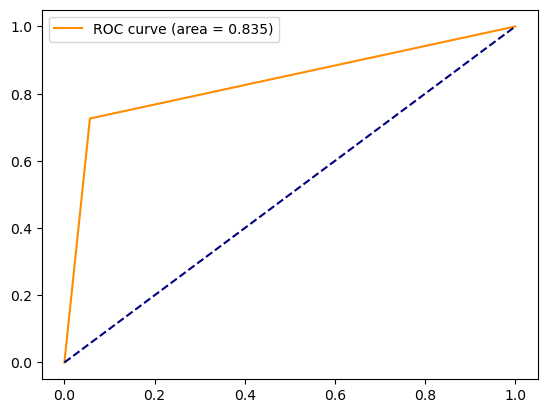

In [267]:
try_model(LogisticRegression, X_train, y_train, X_test, y_test)

In [266]:
model = LogisticRegression()
model.fit(X_train, y_train)
print(model.score(X_train, y_train), model.score(X_test, y_test))
print(model.coef_)

0.7925233644859813 0.8547486033519553
[[-1.1598171  -2.31272323 -1.29182587 -0.20112109 -0.39707107]]


SVC
Accuracy: 0.8324022346368715
Precision: 0.8909090909090909
Recall: 0.6712328767123288
F1 score: 0.7656250000000001


Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC(C=0.1))])

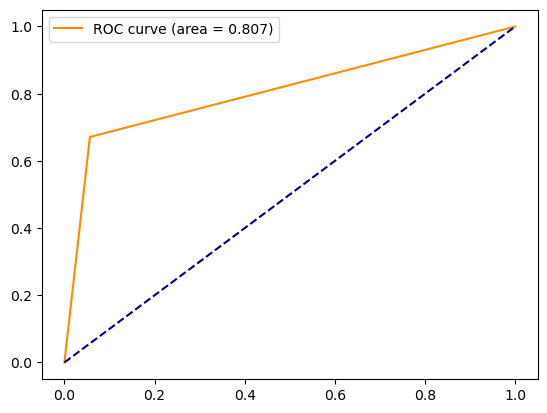

In [241]:
try_model(SVC, X_train, y_train, X_test, y_test, {'C': 0.1})

GaussianNB
Accuracy: 0.8491620111731844
Precision: 0.8026315789473685
Recall: 0.8356164383561644
F1 score: 0.8187919463087249


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gaussiannb', GaussianNB())])

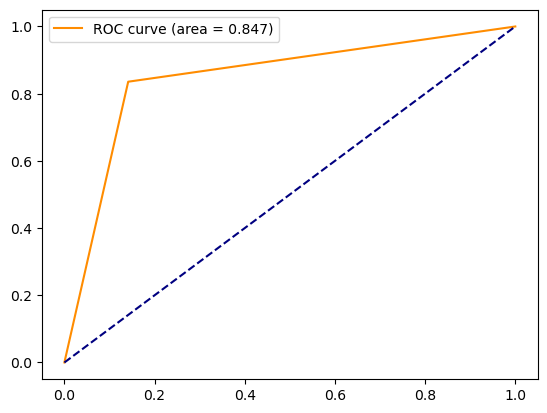

In [130]:
try_model(GaussianNB, X_train, y_train, X_test, y_test)

KNeighborsClassifier
Accuracy: 0.8156424581005587
Precision: 0.7777777777777778
Recall: 0.7671232876712328
F1 score: 0.7724137931034483


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=3))])

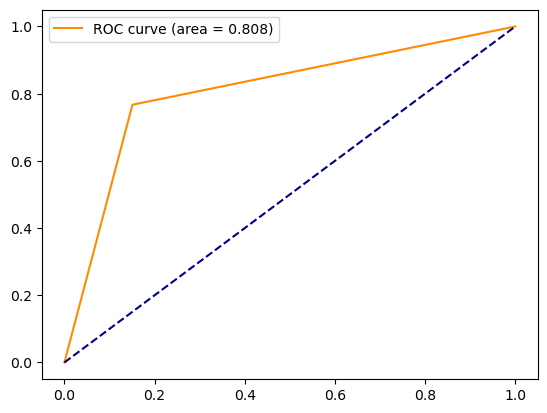

In [50]:
try_model(KNeighborsClassifier, X_train, y_train, X_test, y_test, {'n_neighbors': 3})

In [51]:
res = {}
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=87)
for i in range(1, 11):
    model = KNeighborsClassifier(n_neighbors=i)
    pipeline = make_pipeline(StandardScaler(), model)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    res[i] = {'Accuracy': accuracy_score(y_test, y_pred),
              'Precision': precision_score(y_test, y_pred),
              'Recall': recall_score(y_test, y_pred),
              'F1 score': f1_score(y_test, y_pred)}

In [52]:
sorted(res.items(), key=lambda x: x[1]['F1 score'], reverse=True)

[(7,
  {'Accuracy': 0.8770949720670391,
   'Precision': 0.9047619047619048,
   'Recall': 0.7808219178082192,
   'F1 score': 0.8382352941176471}),
 (8,
  {'Accuracy': 0.8659217877094972,
   'Precision': 0.9152542372881356,
   'Recall': 0.7397260273972602,
   'F1 score': 0.818181818181818}),
 (5,
  {'Accuracy': 0.8603351955307262,
   'Precision': 0.8870967741935484,
   'Recall': 0.7534246575342466,
   'F1 score': 0.8148148148148148}),
 (10,
  {'Accuracy': 0.8491620111731844,
   'Precision': 0.896551724137931,
   'Recall': 0.7123287671232876,
   'F1 score': 0.7938931297709924}),
 (9,
  {'Accuracy': 0.8156424581005587,
   'Precision': 0.7857142857142857,
   'Recall': 0.7534246575342466,
   'F1 score': 0.7692307692307693}),
 (3,
  {'Accuracy': 0.8156424581005587,
   'Precision': 0.7941176470588235,
   'Recall': 0.7397260273972602,
   'F1 score': 0.7659574468085105}),
 (6,
  {'Accuracy': 0.8324022346368715,
   'Precision': 0.9056603773584906,
   'Recall': 0.6575342465753424,
   'F1 score': 0

In [53]:
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [187]:
model.score(X_train, y_train), model.score(X_test, y_test)

ValueError: X has 2 features, but LogisticRegression is expecting 3 features as input.

In [55]:
accuracy_score(y_train, model.predict(X_train)), accuracy_score(y_test, model.predict(X_test))

(0.8168224299065421, 0.8491620111731844)

In [80]:
KNeighborsClassifier?

#### Baseline

In [61]:
# y_pred_1 = np.ones((len(y_test), 1), dtype=np.int8)
# y_pred_1

In [62]:
y_pred_0 = np.zeros((len(y_test), ), dtype=np.int8)
# y_pred_0

In [60]:
# accuracy_score(y_test, y_pred_1)

In [63]:
accuracy_score(y_test, y_pred_0)

0.5921787709497207

In [65]:
np.mean(y_test == y_pred_0)

0.5921787709497207

In [73]:
pd.Series(y_test).value_counts(normalize=True)

0    0.592179
1    0.407821
dtype: float64